<a href="https://colab.research.google.com/github/Sadaf-Khademi/COMP478FinalProject/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/Othercomputers/My Laptop/Google Drive/Lung


/content/drive/Othercomputers/My Laptop/Google Drive/Lung


In [ ]:
import os
import numpy as np
import pandas as pd
from random import seed
import cv2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import utils, optimizers, losses, callbacks
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from statistics import mean
import matplotlib.pyplot as plt
from keras.models import Model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, roc_curve, auc

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.random.set_seed(100)
seed(100)

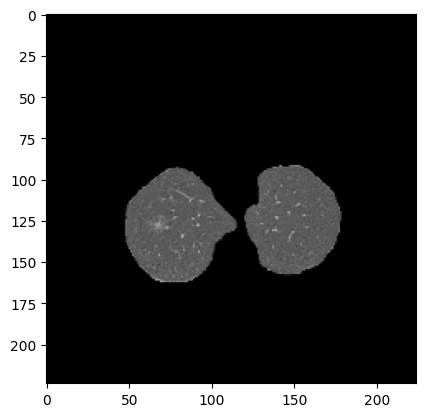

In [ ]:
inputdata = np.zeros((1,224,224,3))
for i in range(114):
  a = np.load(f'ID {i+1}-lung.npy')
  for j in range(a.shape[0]):
    stacked_img = np.stack((cv2.resize(a[j,:,:,0],(224,224)),)*3, axis=-1)
    c = np.expand_dims(stacked_img, axis=0)
    inputdata = np.concatenate((inputdata, c), axis=0)

mydata = inputdata[1:,:,:,:]

plt.imshow(mydata[106,:,:,:])
plt.show()

In [ ]:
def import_labels(label_dir='labels_csv.csv'):
  
  labels = pd.read_csv(label_dir)

  labels.columns = ['ID',
                    'Patch_Code',
                    'Lobar_Location_of_Nodule',
                    'Age',
                    'Gender',
                    'Smoking']
  return labels


def aggregate_labels(cols): # to merge classes 1 and 2 as class 0
  if cols == 1 or cols == 2:
    return 0
  elif cols == 3:
    return 1
  else:
    raise ValueError('Labels should be 1, 2, or 3.')

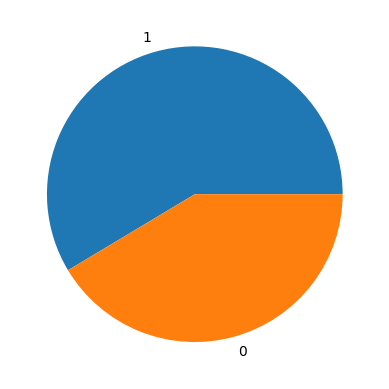

In [ ]:
labels = import_labels()
labels['Agg_Patch_Code'] = labels['Patch_Code'].apply(aggregate_labels)  
mylabel = labels['Agg_Patch_Code']

mylabel.value_counts().plot(kind='pie')
plt.ylabel('')
plt.show()

In [ ]:
skf = StratifiedKFold(n_splits=10)

acc_list = []
sens_list = []
spec_list = []
auc_list = []
Loss_value = []
Acc_value = []

fold = 0
for train_index, test_index in skf.split(mydata, mylabel):
  fold = fold + 1
  x_train, x_test = mydata[train_index], mydata[test_index]
  y_train, y_test = mylabel[train_index], mylabel[test_index]
  y_train = utils.to_categorical((y_train), num_classes=2)
  y_test = utils.to_categorical((y_test), num_classes=2)

  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  for layer in base_model.layers:
    layer.trainable = False
  x = Flatten()(base_model.output)
  logits = Dense(2, activation='softmax')(x)
  adam = optimizers.Adam(learning_rate=1e-4)
  bce = losses.BinaryCrossentropy()
  model = Model(inputs=base_model.input, outputs=logits)

  model.compile(loss=bce, optimizer=adam, metrics=['accuracy'])
  

  batch_size = 32
  epochs = 100
  save_weight_path = r'C:/Users/isip/Desktop/CAE-Transformer-main1/tweight/'
  save_weight_name = f'fold{fold}.h5'
  filepath = save_weight_path + save_weight_name
  checkpoint = callbacks.ModelCheckpoint(filepath,
                                         monitor='loss',
                                         verbose=2,
                                         save_best_only=True,
                                         mode='min')
  callbacks_list = [checkpoint]

  history = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split = 0,
                      shuffle=True,
                      callbacks=callbacks_list,
                      verbose=2)

  # summarize history for accuracy & loss
  Acc_value.append(history.history['accuracy'])
  Loss_value.append(history.history['loss'])



  model.load_weights(save_weight_path + save_weight_name)

  THRESHOLD = 0.5
  result_probs = model.predict(x_test)
  result_classes = np.argmax(result_probs, axis=-1)

  acc_list.append(accuracy_score(y_test[:, 1], result_classes))
  sens_list.append(recall_score(y_test[:, 1], result_classes))
  spec_list.append(recall_score(y_test[:, 0], np.argmin(result_probs, axis=-1)))

  
  result_df = pd.DataFrame()
  result_df['Label'] = y_test[:, 1]
  result_df['Prediction'] = result_classes

  target_names = ['benign', 'malignant']
  print(classification_report(y_test[:,1], result_classes, target_names=target_names))
  conf_matrix = confusion_matrix(y_true=y_test[:,1], y_pred=result_classes)

  fig, ax = plt.subplots(figsize=(7.5, 7.5))
  ax.matshow(conf_matrix, cmap=plt.cm.Greens, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
      ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

  plt.xlabel('Predicted Label', fontsize=18)
  plt.ylabel('Actual Label', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()
  print(confusion_matrix(y_test[:,1], result_classes))
  del model

In [ ]:
LH = np.array(Loss_value)
AH = np.array(Acc_value)
fig, ax = plt.subplots()
for fold_history in LH:
  ax.plot(fold_history)

In [ ]:
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss for all folds')
ax.legend(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Fold 6', 'Fold 7', 'Fold 8', 'Fold 9', 'Fold 10'])
plt.show()

In [ ]:
fig, ax = plt.subplots()
for fold_history in AH:
  ax.plot(fold_history)

In [ ]:
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training Accuracy for all folds')
ax.legend(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Fold 6', 'Fold 7', 'Fold 8', 'Fold 9', 'Fold 10'])
plt.show()

In [ ]:
# Displaying the results
print('Training Finished.')
print('Accuracy:')
print(acc_list)
print('Total: ', mean(acc_list))
print('--------------')
print('Sensitivity:')
print(sens_list)
print('Total: ', mean(sens_list))
print('--------------')
print('Specificity:')
print(spec_list)
print('Total: ', mean(spec_list))
